In [458]:
import pandas as pd
import numpy as np
import json
# import psycopg2
# from sqlalchemy import create_engine
# import os
# from dotenv import load_dotenv
# load_dotenv()

# from script.database_pipeline import Pipeline
from script.helper import *

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

In [459]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting up DB

**Decided to put database on hold**

In [460]:
# username = os.getenv('PSQL_USER')
# password = os.getenv('PASS')
# host = os.getenv('HOST')
# port = os.getenv('PORT')

# db_url = (f"postgresql+psycopg2://{username}:{password}@{host}:{port}/data_prof")

In [461]:
# engine = create_engine(db_url)

In [462]:
# Converted into a csv
df = pd.read_csv('ds_2019.csv')

In [463]:
# pipe = Pipeline(engine)
# pipe.add_table(df, 'og')

### EDA

Exploring and cleaning

### Looking at overall US

Breaking down into 3 groups

In [464]:
us = df[df['Country'] == 'United States'].copy()

In [465]:
us_cleaned = us.copy()

In [466]:
looking = us['LookingForAnotherJob'].value_counts().index

In [467]:
looking_map = { v: i for i, v in enumerate(looking)}

In [468]:
us_cleaned.loc[:, 'LookingForAnotherJob'] = us['LookingForAnotherJob'].map(looking_map)

In [469]:
features = ['SalaryUSD', 'PostalCode', 'YearsWithThisDatabase', 'PrimaryDatabase', 'OtherDatabases', 'JobTitle', 'ManageStaff', 'YearsWithThisTypeOfJob', 'OtherPeopleOnYourTeam', \
            'DatabaseServers', 'Education', 'HoursWorkedPerWeek', 'TelecommuteDaysPerWeek', 'EmploymentSector', \
            'Gender', 'OtherJobDuties']
target = ['LookingForAnotherJob']

In [470]:
us_cleaned = us_cleaned.loc[:, features+target]

In [471]:
nl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 0]
pl_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 1]
al_cleaned = us_cleaned[us_cleaned['LookingForAnotherJob'] == 2]

### Salary

In [472]:
us_cleaned.loc[:, 'SalaryUSD'] = us['SalaryUSD'].apply(str).replace(',|\s+', '', regex=True).astype(float)

In [473]:
nl_sal = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 0, 'SalaryUSD']
pl_sal = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 1, 'SalaryUSD']
al_sal = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 2, 'SalaryUSD']

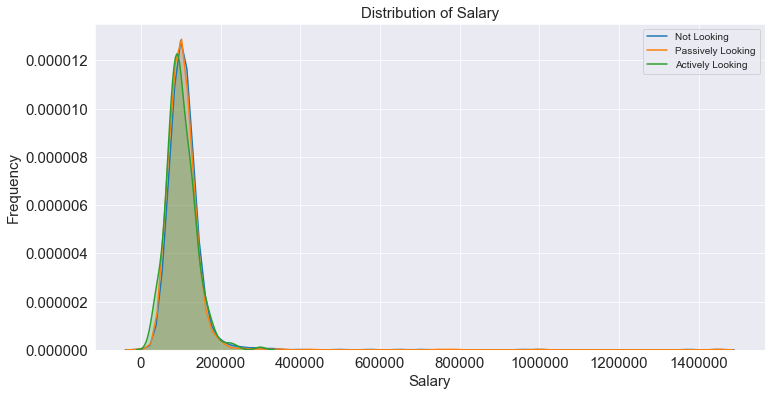

In [474]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_sal, pl_sal, al_sal, xlabel='Salary', ylabel='Frequency',
            title='Distribution of Salary'))

### Remove salary outliers

In [475]:
def outliers_removed(series):
    q3 = series.quantile(.75)
    q1 = series.quantile(.25)
    
    iqr = q3 - q1
    mask = ((series < (q3 + 1.5 * iqr)) & (series > (q1 - 1.5 * iqr)))
    
    return series[mask]

In [476]:
nl_salary_adj = outliers_removed(nl_sal)
pl_salary_adj = outliers_removed(pl_sal)
al_salary_adj = outliers_removed(al_sal)

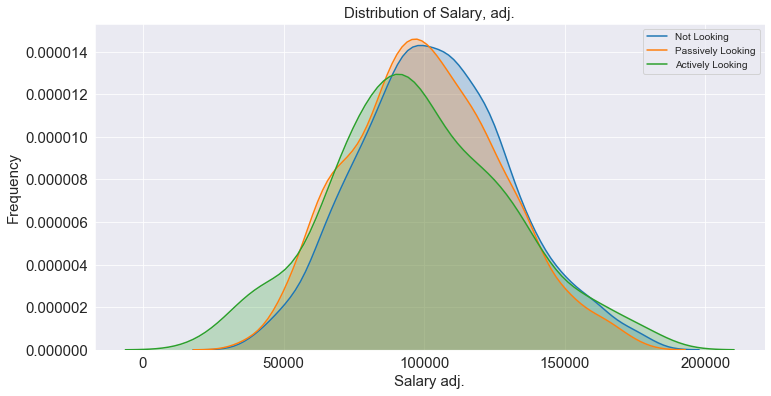

In [477]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_salary_adj, pl_salary_adj, al_salary_adj, xlabel='Salary adj.', ylabel='Frequency',
            title='Distribution of Salary, adj.'))

### Postal Code

In [478]:
print('Total num of na:', nl_cleaned['PostalCode'].isna().sum())
print('Total num of Not Asked:', (nl_cleaned['PostalCode'] != 'Not Asked').sum())

Total num of na: 164
Total num of Not Asked: 1400


In [479]:
print('Total num of na:', pl_cleaned['PostalCode'].isna().sum())
print('Total num of Not Asked:', (pl_cleaned['PostalCode'] != 'Not Asked').sum())

Total num of na: 122
Total num of Not Asked: 1039


In [480]:
print('Total num of na:', al_cleaned['PostalCode'].isna().sum())
print('Total num of Not Asked:', (al_cleaned['PostalCode'] != 'Not Asked').sum())

Total num of na: 16
Total num of Not Asked: 191


### Primary Database

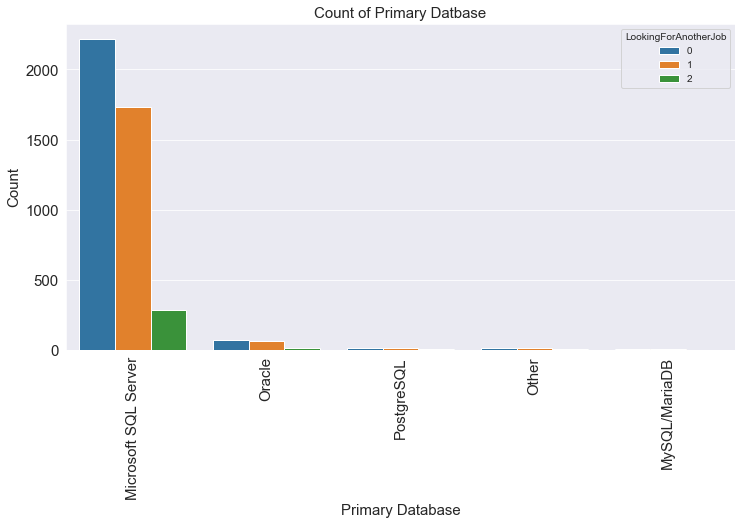

In [481]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, 'PrimaryDatabase', us_cleaned, xlabel='Primary Database', ylabel='Count', 
              title='Count of Primary Datbase', hue='LookingForAnotherJob', order=us_cleaned['PrimaryDatabase'].value_counts().index[:5]))

_ = ax.set_xticklabels(us_cleaned['PrimaryDatabase'].value_counts().index, rotation=90)

### Other Databases

In [482]:
us_cleaned['OtherDatabases'].value_counts()

Microsoft SQL Server                                                                                                     360
Microsoft Access                                                                                                         188
Oracle                                                                                                                   167
Azure SQL DB                                                                                                             119
Microsoft SQL Server, Microsoft Access                                                                                   105
                                                                                                                        ... 
Microsoft SQL Server, MySQL/MariaDB, Microsoft Access, Teradata, Azure SQL DB                                              1
Microsoft SQL Server, Oracle, Microsoft Access, SQLite, Azure SQL DB                                                       1


In [483]:
us_cleaned['od_count'] = us_cleaned['OtherDatabases'].str.split(',').str.len()

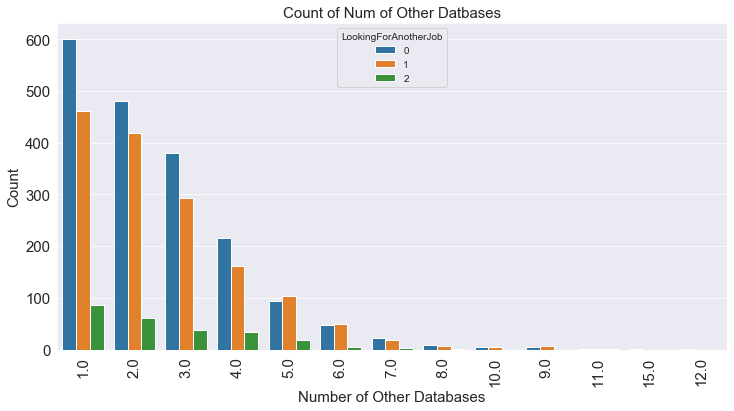

In [484]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, 'od_count', us_cleaned, xlabel='Number of Other Databases', ylabel='Count', 
              hue='LookingForAnotherJob', title='Count of Num of Other Datbases'))

_ = ax.set_xticklabels(us_cleaned['od_count'].value_counts().index, rotation=90)

### Years with this database

In [485]:
nl_yeardb = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 0, 'YearsWithThisDatabase']
pl_yeardb = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 1, 'YearsWithThisDatabase']
al_yeardb = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 2, 'YearsWithThisDatabase']

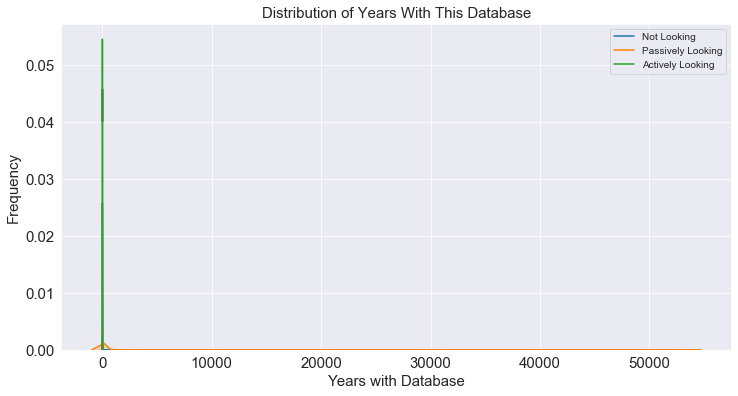

In [486]:
fig, ax = plt.subplots(figsize=(12, 6))

(plot_kde(ax, nl_yeardb, pl_yeardb, al_yeardb, xlabel='Years with Database', ylabel='Frequency',
            title='Distribution of Years With This Database'))

In [487]:
us_cleaned.loc[:, 'YearsWithThisDatabase'] = us.loc[us['YearsWithThisDatabase'] < 100, 'YearsWithThisDatabase']

In [488]:
nl_yeardb_adj = outliers_removed(nl_yeardb)
pl_yeardb_adj = outliers_removed(pl_yeardb)
al_yeardb_adj = outliers_removed(al_yeardb)

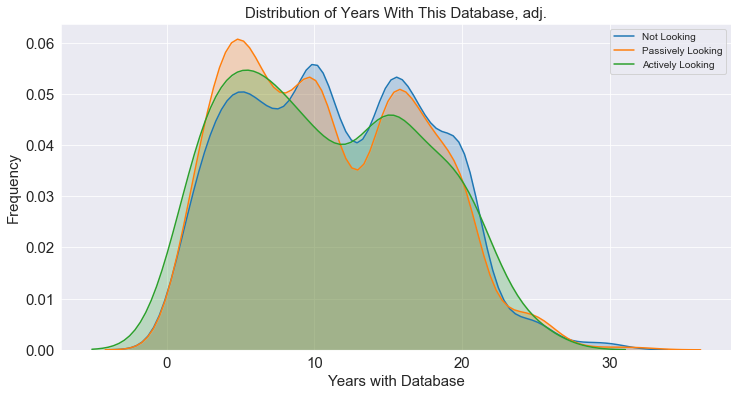

In [489]:
fig, ax = plt.subplots(figsize=(12, 6))

(plot_kde(ax, nl_yeardb_adj, pl_yeardb_adj, al_yeardb_adj, xlabel='Years with Database', ylabel='Frequency',
            title='Distribution of Years With This Database, adj.'))

### EmploymentStatus

In [490]:
def transform_empstatus(row):
    if 'Full time employee' in row:
        return 'Full time employee'
    elif 'Independent' in row:
        return 'Independent'
    return 'Part time'

In [491]:
us_cleaned.loc[:, 'EmploymentStatus'] = us['EmploymentStatus'].apply(transform_empstatus)

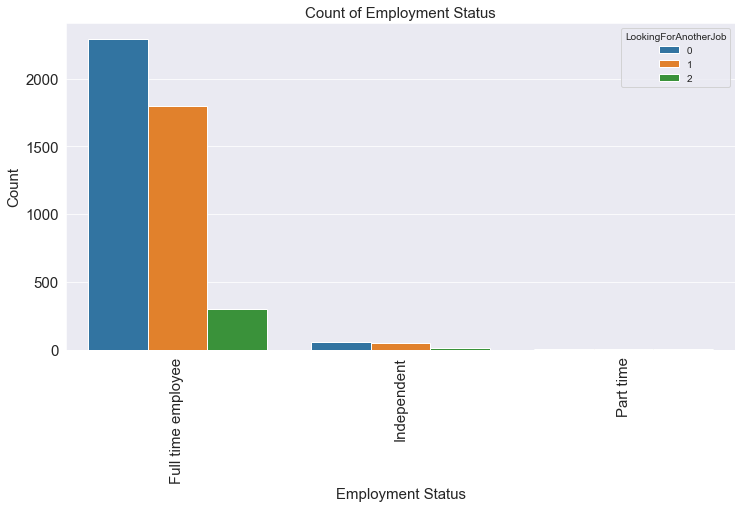

In [492]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, 'EmploymentStatus', us_cleaned, xlabel='Employment Status', ylabel='Count', 
              hue='LookingForAnotherJob', title='Count of Employment Status'))

_ = ax.set_xticklabels(us_cleaned['EmploymentStatus'].value_counts().index, rotation=90)

### JobTitle

In [493]:
def transform_job(row):
    if 'DBA' in row:
        return 'DBA'
    elif 'Developer' in row:
        return 'Developer'
    return row

In [494]:
us_cleaned

,SalaryUSD,PostalCode,YearsWithThisDatabase,PrimaryDatabase,OtherDatabases,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,LookingForAnotherJob,od_count,EmploymentStatus
0,200000.0,Not Asked,10.0,Microsoft SQL Server,MySQL/MariaDB,DBA,No,5,2,350,Masters,45,1,Private business,Not Asked,Not Asked,1,1.0,Full time employee
12,137500.0,Not Asked,16.0,Microsoft SQL Server,"Azure SQL DB, Amazon RDS (any flavor)",DBA,No,6,4,200,None (no degree completed),55,5 or more,Private business,Not Asked,Not Asked,0,2.0,Full time employee
14,85000.0,Not Asked,8.0,Microsoft SQL Server,"MySQL/MariaDB, PostgreSQL, Microsoft Access",DBA,No,2,None,15,Bachelors (4 years),50,"None, or less than 1 day per week",Private business,Not Asked,Not Asked,1,3.0,Full time employee
15,96000.0,Not Asked,5.0,Microsoft SQL Server,Microsoft Access,DBA,No,5,None,100,Masters,45,1,Private business,Not Asked,Not Asked,1,1.0,Full time employee
17,66000.0,Not Asked,10.0,Microsoft SQL Server,"Microsoft SQL Server, PostgreSQL, MongoDB, Mic...","Developer: App code (C#, JS, etc)",No,10,None,4,Associates (2 years),60,5 or more,Private business,Not Asked,Not Asked,1,7.0,Full time employee
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6883,101500.0,44122,8.0,Microsoft SQL Server,"Microsoft SQL Server, Oracle, Azure SQL DB",DBA (Production Focus - build & troubleshoot s...,No,9,3,185,Bachelors (4 years),43,1,Private business,Male,NaN,0,3.0,Full time employee
6884,107000.0,29201,9.0,Microsoft SQL Server,NaN,DBA (Production Focus - build & troubleshoot s...,No,8,None,67,Bachelors (4 years),45,1,Private business,Male,Engineer,1,NaN,Full time employee
6886,132000.0,03873,20.0,Microsoft SQL Server,Azure SQL DB,"DBA (Development Focus - tunes queries, indexe...",No,20,3,500,Bachelors (4 years),45,5 or more,Private business,Male,"Architect, DBA (General - splits time evenly b...",0,1.0,Full time employee
6887,58500.0,50266,5.0,Microsoft SQL Server,"Oracle, Microsoft Access",Analyst,No,5,1,1,Associates (2 years),40,"None, or less than 1 day per week",Private business,Male,"DBA (Development Focus - tunes queries, indexe...",0,2.0,Full time employee


In [495]:
us_cleaned['JobTitle']

0                                                     DBA
12                                                    DBA
14                                                    DBA
15                                                    DBA
17                      Developer: App code (C#, JS, etc)
                              ...                        
6883    DBA (Production Focus - build & troubleshoot s...
6884    DBA (Production Focus - build & troubleshoot s...
6886    DBA (Development Focus - tunes queries, indexe...
6887                                              Analyst
6891    DBA (General - splits time evenly between writ...
Name: JobTitle, Length: 4509, dtype: object

In [496]:
us_cleaned.loc[:, 'JobTitle'] = us_cleaned['JobTitle'].apply(transform_job)

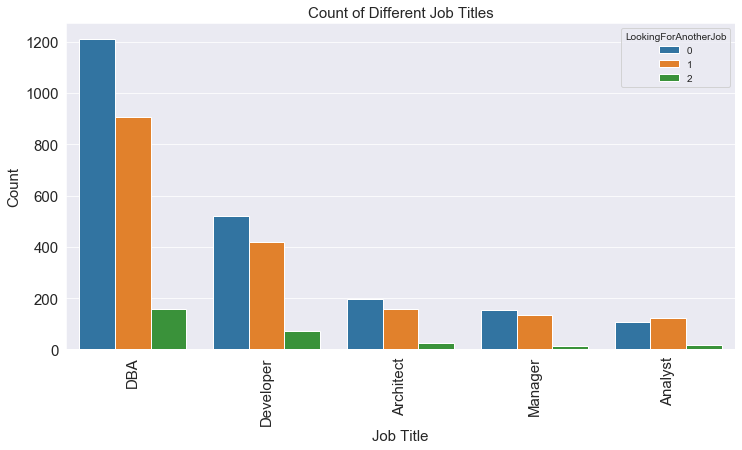

In [497]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, 'JobTitle', us_cleaned, xlabel='Job Title', ylabel='Count', 
         hue='LookingForAnotherJob', title='Count of Different Job Titles', order=us_cleaned['JobTitle'].value_counts().index[:5]))

_ = ax.set_xticklabels(us_cleaned['JobTitle'].value_counts().index, rotation=90)

### Manage Staff

In [498]:
us_cleaned['ManageStaff'].value_counts()

No     3498
Yes    1011
Name: ManageStaff, dtype: int64

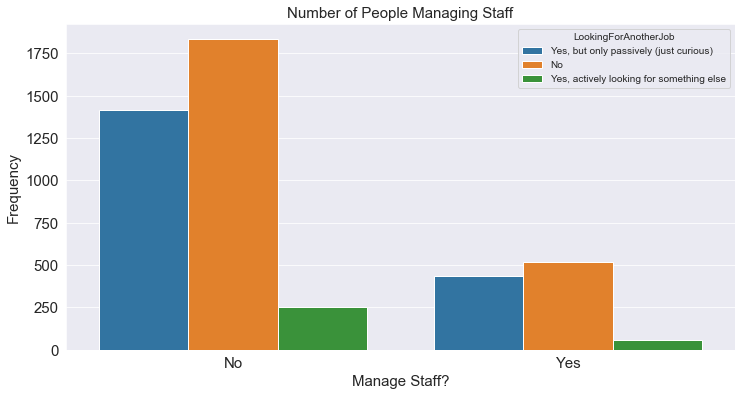

In [499]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, 'ManageStaff', us, xlabel='Manage Staff?', ylabel='Frequency', 
              hue='LookingForAnotherJob', title='Number of People Managing Staff'))

### Years With This Type of Job

In [500]:
us_cleaned['YearsWithThisTypeOfJob'].value_counts().sort_index()

0      38
1     531
2     520
3     499
4     397
5     448
6     257
7     212
8     184
9      80
10    326
11     59
12    119
13     51
14     37
15    186
16     52
17     69
18     72
19     26
20    150
21     20
22     30
23     14
24      9
25     49
26      7
27      6
28     10
29      8
30     18
31      2
32      6
33      2
34      2
35      4
36      2
37      1
38      3
39      1
40      2
Name: YearsWithThisTypeOfJob, dtype: int64

In [501]:
nl_yrjb = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 0, 'YearsWithThisTypeOfJob']
pl_yrjb = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 1, 'YearsWithThisTypeOfJob']
al_yrjb = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 2, 'YearsWithThisTypeOfJob']

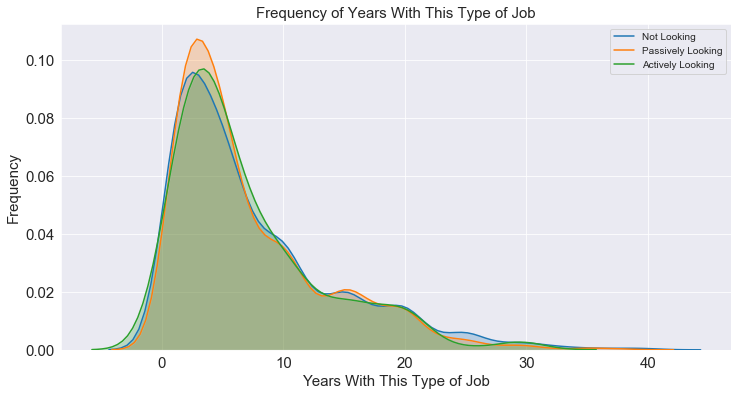

In [502]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_yrjb, pl_yrjb, al_yrjb,xlabel='Years With This Type of Job', ylabel='Frequency',
            title='Frequency of Years With This Type of Job'))

### Amount of Others on Your Team

Label Encode ordinality

In [503]:
us_cleaned['OtherPeopleOnYourTeam'].value_counts()

None           1842
1               942
2               521
More than 5     422
3               378
4               239
5               165
Name: OtherPeopleOnYourTeam, dtype: int64

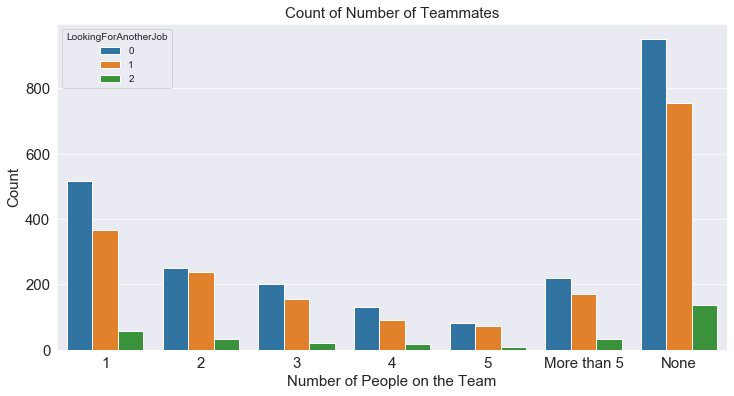

In [504]:
fig, ax = plt.subplots(figsize=(12, 6))

(plot_cat(ax, 'OtherPeopleOnYourTeam', us_cleaned, xlabel='Number of People on the Team', ylabel='Count',
            hue='LookingForAnotherJob', title='Count of Number of Teammates', order=us['OtherPeopleOnYourTeam'].value_counts().sort_index().index))



### Education Level

Label Encode ordinality

In [505]:
us_cleaned['Education'].value_counts()

Bachelors (4 years)           2548
Masters                        762
None (no degree completed)     672
Associates (2 years)           503
Doctorate/PhD                   24
Name: Education, dtype: int64

In [506]:
us_cleaned.loc[:, 'Education'] = us['Education'].str.replace('\\(.*\\)', '', regex=True).str.strip()

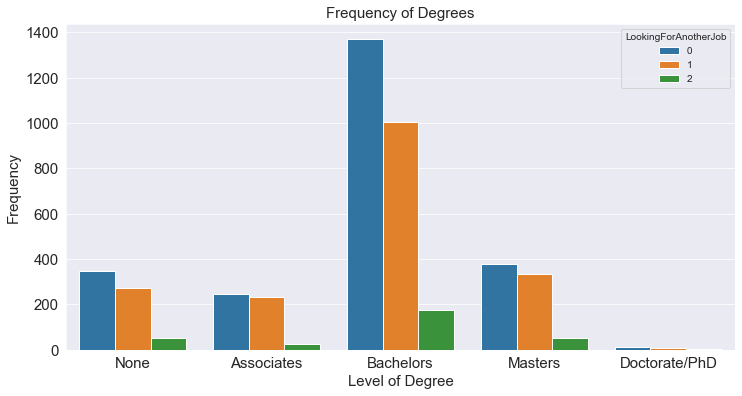

In [507]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, 'Education', us_cleaned, xlabel='Level of Degree', ylabel='Frequency', 
         hue='LookingForAnotherJob', title='Frequency of Degrees', order=['None', 'Associates', 'Bachelors', 'Masters', 'Doctorate/PhD'])
)

### Hours Worked Per Week

In [508]:
nl_hours = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 0, 'HoursWorkedPerWeek']
pl_hours = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 1, 'HoursWorkedPerWeek']
al_hours = us_cleaned.loc[us_cleaned['LookingForAnotherJob'] == 2, 'HoursWorkedPerWeek']

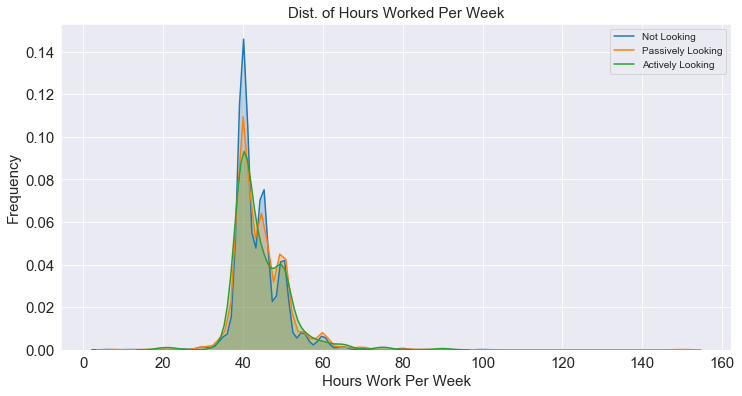

In [509]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_hours, pl_hours, al_hours, xlabel='Hours Work Per Week', ylabel='Frequency',
            title='Dist. of Hours Worked Per Week'))

### Telecommute Days Per Week

Label Encode ordinality

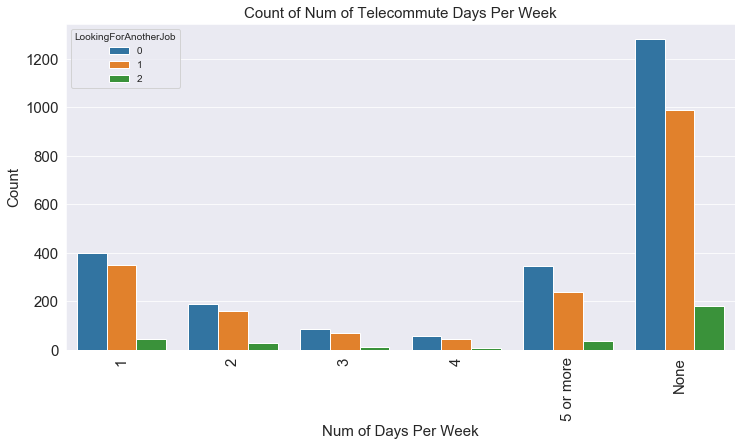

In [510]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, 'TelecommuteDaysPerWeek', us_cleaned, xlabel='Num of Days Per Week', ylabel='Count',
          hue='LookingForAnotherJob',   
          title='Count of Num of Telecommute Days Per Week', 
          order=us_cleaned['TelecommuteDaysPerWeek'].value_counts().sort_index().index))

_ = ax.set_xticklabels(['1', '2', '3', '4', '5 or more', 'None'], rotation=90)



### Employment Sector

Maybe OHE

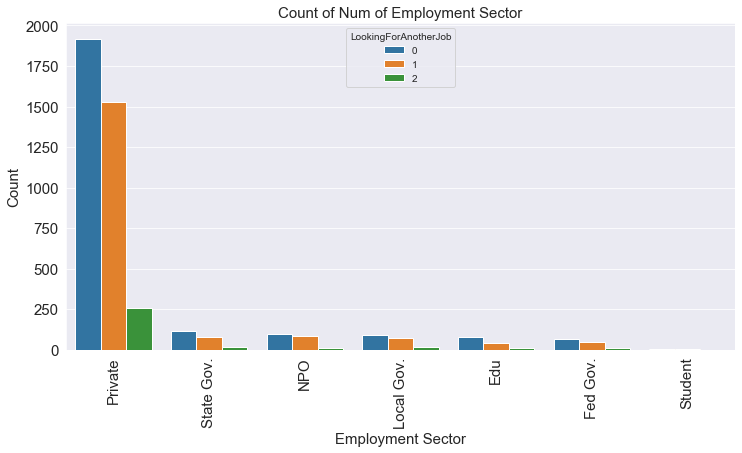

In [511]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, 'EmploymentSector', us_cleaned, xlabel='Employment Sector', ylabel='Count',
          hue='LookingForAnotherJob',
          title='Count of Num of Employment Sector', order=us_cleaned['EmploymentSector'].value_counts().index))

_ = ax.set_xticklabels(['Private', 'State Gov.', 'NPO', 'Local Gov.', 'Edu', 'Fed Gov.', 'Student'], rotation=90)

### Gender

Might have to drop gender due to high number of third category/random answers/Not Asked.

In [512]:
def clean_gender(row):
    if (row not in ['Male', 'Female', 'Not Asked']):
        return 'Other'
    return row

In [513]:
us_cleaned.loc[:, 'Gender'] = us['Gender'].apply(clean_gender)

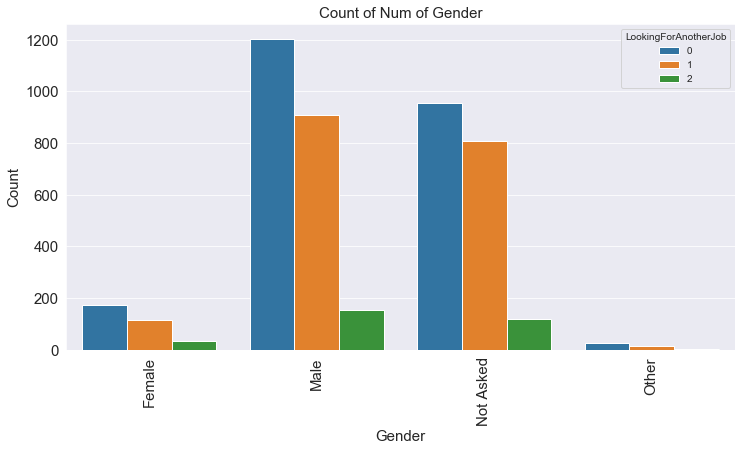

In [514]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, 'Gender', us_cleaned, xlabel='Gender', ylabel='Count',
          hue='LookingForAnotherJob',
          title='Count of Num of Gender', order=us_cleaned['Gender'].value_counts().sort_index().index))

_ = ax.set_xticklabels(us_cleaned['Gender'].value_counts().sort_index().index, rotation=90)

### Amount of Other Job Duties

Might have to exclude, due to high number of nans/No answers

In [515]:
us['OtherJobDuties'].replace('Not Asked', np.nan).isna().mean()

0.5021068973164782

In [516]:
def transform_ojd(row):
    if (row == 'Not Asked'):
        return ['N/A']
    return row.split(',')

def count_ojd(row):
    if ('N/A' in row):
        return np.nan
    elif ('None' in row):
        return 0
    return len(row)

In [517]:
us_cleaned['ojd_count'] = (us['OtherJobDuties'].replace(np.nan, 'None')
                                               .str.strip()
                                               .replace('\\(.*\\)', '', regex=True)
                                               .apply(transform_ojd)
                                               .apply(count_ojd))

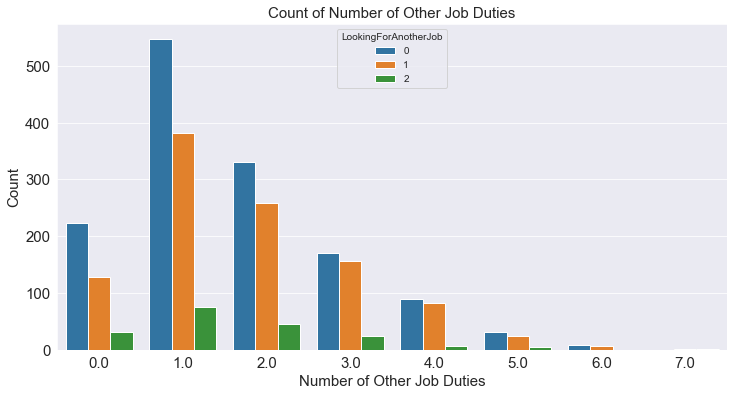

In [518]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_cat(ax, 'ojd_count', us_cleaned, xlabel='Number of Other Job Duties', ylabel='Count', 
          hue='LookingForAnotherJob', title='Count of Number of Other Job Duties'))

In [519]:
features += ['od_count', 'ojd_count']

In [520]:
features

['SalaryUSD',
 'PostalCode',
 'YearsWithThisDatabase',
 'PrimaryDatabase',
 'OtherDatabases',
 'JobTitle',
 'ManageStaff',
 'YearsWithThisTypeOfJob',
 'OtherPeopleOnYourTeam',
 'DatabaseServers',
 'Education',
 'HoursWorkedPerWeek',
 'TelecommuteDaysPerWeek',
 'EmploymentSector',
 'Gender',
 'OtherJobDuties',
 'od_count',
 'ojd_count']

### Feature Engineering

In [521]:
X = us_cleaned.loc[:, features + target]

In [522]:
X.head()

,SalaryUSD,PostalCode,YearsWithThisDatabase,PrimaryDatabase,OtherDatabases,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob
0,200000.0,Not Asked,10.0,Microsoft SQL Server,MySQL/MariaDB,DBA,No,5,2,350,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1
12,137500.0,Not Asked,16.0,Microsoft SQL Server,"Azure SQL DB, Amazon RDS (any flavor)",DBA,No,6,4,200,None,55,5 or more,Private business,Not Asked,Not Asked,2.0,NaN,0
14,85000.0,Not Asked,8.0,Microsoft SQL Server,"MySQL/MariaDB, PostgreSQL, Microsoft Access",DBA,No,2,None,15,Bachelors,50,"None, or less than 1 day per week",Private business,Not Asked,Not Asked,3.0,NaN,1
15,96000.0,Not Asked,5.0,Microsoft SQL Server,Microsoft Access,DBA,No,5,None,100,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1
17,66000.0,Not Asked,10.0,Microsoft SQL Server,"Microsoft SQL Server, PostgreSQL, MongoDB, Mic...",Developer,No,10,None,4,Associates,60,5 or more,Private business,Not Asked,Not Asked,7.0,NaN,1


### SalaryUSD

Cleaning erroneous values

In [523]:
X = X.drop(X[X['SalaryUSD'] < 100].index)

In [524]:
X.head()

,SalaryUSD,PostalCode,YearsWithThisDatabase,PrimaryDatabase,OtherDatabases,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob
0,200000.0,Not Asked,10.0,Microsoft SQL Server,MySQL/MariaDB,DBA,No,5,2,350,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1
12,137500.0,Not Asked,16.0,Microsoft SQL Server,"Azure SQL DB, Amazon RDS (any flavor)",DBA,No,6,4,200,None,55,5 or more,Private business,Not Asked,Not Asked,2.0,NaN,0
14,85000.0,Not Asked,8.0,Microsoft SQL Server,"MySQL/MariaDB, PostgreSQL, Microsoft Access",DBA,No,2,None,15,Bachelors,50,"None, or less than 1 day per week",Private business,Not Asked,Not Asked,3.0,NaN,1
15,96000.0,Not Asked,5.0,Microsoft SQL Server,Microsoft Access,DBA,No,5,None,100,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1
17,66000.0,Not Asked,10.0,Microsoft SQL Server,"Microsoft SQL Server, PostgreSQL, MongoDB, Mic...",Developer,No,10,None,4,Associates,60,5 or more,Private business,Not Asked,Not Asked,7.0,NaN,1


### PostalCode

In [525]:
with open('postcodeclean.json', 'r') as f:
    results_combined = json.load(f)

In [526]:
def transform_zipcode(row):
    if row in results_combined:
        return results_combined[row]
    return row

In [527]:
X.loc[:, 'PostalCodeStates'] = X['PostalCode'].apply(transform_zipcode)

In [528]:
X = X.drop('PostalCode', axis=1)

In [529]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,OtherDatabases,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,MySQL/MariaDB,DBA,No,5,2,350,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,"Azure SQL DB, Amazon RDS (any flavor)",DBA,No,6,4,200,None,55,5 or more,Private business,Not Asked,Not Asked,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,"MySQL/MariaDB, PostgreSQL, Microsoft Access",DBA,No,2,None,15,Bachelors,50,"None, or less than 1 day per week",Private business,Not Asked,Not Asked,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,Microsoft Access,DBA,No,5,None,100,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,"Microsoft SQL Server, PostgreSQL, MongoDB, Mic...",Developer,No,10,None,4,Associates,60,5 or more,Private business,Not Asked,Not Asked,7.0,NaN,1,Not Asked


### ManageStaff

Change it into a categorical variable

In [530]:
ms = X['ManageStaff'].value_counts().index

In [531]:
ms_map = {v: i for i, v in enumerate(ms)}

In [532]:
X.loc[:, 'ManageStaff'] = X['ManageStaff'].map(ms_map)

In [533]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,OtherDatabases,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,MySQL/MariaDB,DBA,0,5,2,350,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,"Azure SQL DB, Amazon RDS (any flavor)",DBA,0,6,4,200,None,55,5 or more,Private business,Not Asked,Not Asked,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,"MySQL/MariaDB, PostgreSQL, Microsoft Access",DBA,0,2,None,15,Bachelors,50,"None, or less than 1 day per week",Private business,Not Asked,Not Asked,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,Microsoft Access,DBA,0,5,None,100,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,"Microsoft SQL Server, PostgreSQL, MongoDB, Mic...",Developer,0,10,None,4,Associates,60,5 or more,Private business,Not Asked,Not Asked,7.0,NaN,1,Not Asked


### OtherDatabases

In [534]:
X = X.drop('OtherDatabases', axis=1)

### OtherPeopleOnYourTeam

In [535]:
others_map = {'None': 0, 
              '1': 1, 
              '2': 2,
              '3': 3,
              '4': 4,
              '5': 5,
             'More than 5': 6}

In [536]:
X.loc[:, 'OtherPeopleOnYourTeam'] = X['OtherPeopleOnYourTeam'].map(others_map)

In [537]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,DBA,0,5,2,350,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,DBA,0,6,4,200,None,55,5 or more,Private business,Not Asked,Not Asked,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,DBA,0,2,0,15,Bachelors,50,"None, or less than 1 day per week",Private business,Not Asked,Not Asked,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,DBA,0,5,0,100,Masters,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,Developer,0,10,0,4,Associates,60,5 or more,Private business,Not Asked,Not Asked,7.0,NaN,1,Not Asked


### Education

In [538]:
edu_map = {
    'None': 0,
    'Associates': 1,
    'Bachelors': 2,
    'Masters': 3,
    'Doctorate/PhD': 4
}

In [539]:
X.loc[:, 'Education'] = X['Education'].map(edu_map)

In [540]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,DBA,0,5,2,350,3,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,DBA,0,6,4,200,0,55,5 or more,Private business,Not Asked,Not Asked,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,DBA,0,2,0,15,2,50,"None, or less than 1 day per week",Private business,Not Asked,Not Asked,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,DBA,0,5,0,100,3,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,Developer,0,10,0,4,1,60,5 or more,Private business,Not Asked,Not Asked,7.0,NaN,1,Not Asked


### TelecommuteDaysPerWeek

In [541]:
tele_map = {
    'None, or less than 1 day per week': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5 or more': 5
}

In [542]:
X.loc[:, 'TelecommuteDaysPerWeek'] = X['TelecommuteDaysPerWeek'].map(tele_map)

In [543]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,DBA,0,5,2,350,3,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,DBA,0,6,4,200,0,55,5,Private business,Not Asked,Not Asked,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,DBA,0,2,0,15,2,50,0,Private business,Not Asked,Not Asked,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,DBA,0,5,0,100,3,45,1,Private business,Not Asked,Not Asked,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,Developer,0,10,0,4,1,60,5,Private business,Not Asked,Not Asked,7.0,NaN,1,Not Asked


### EmploymentSector

In [544]:
# Get dummies later

# X = pd.concat([X, pd.get_dummies(X['EmploymentSector'])], axis=1)
# X = X.drop('EmploymentSector', axis=1)

In [545]:
sectors = X['EmploymentSector'].value_counts().index

In [546]:
sector_map = {v: i for i, v in enumerate(sectors)}

In [547]:
X.loc[:, 'EmploymentSector'] = X['EmploymentSector'].map(sector_map)

In [548]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,DBA,0,5,2,350,3,45,1,0,Not Asked,Not Asked,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,DBA,0,6,4,200,0,55,5,0,Not Asked,Not Asked,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,DBA,0,2,0,15,2,50,0,0,Not Asked,Not Asked,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,DBA,0,5,0,100,3,45,1,0,Not Asked,Not Asked,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,Developer,0,10,0,4,1,60,5,0,Not Asked,Not Asked,7.0,NaN,1,Not Asked


### Gender

In [549]:
gender_map = {
    'Female': 0,
    'Male': 1,
    'Other': 3,
    'Not Asked': np.nan
}

In [550]:
X.loc[:, 'Gender'] = X['Gender'].map(gender_map)

In [551]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,OtherJobDuties,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,DBA,0,5,2,350,3,45,1,0,NaN,Not Asked,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,DBA,0,6,4,200,0,55,5,0,NaN,Not Asked,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,DBA,0,2,0,15,2,50,0,0,NaN,Not Asked,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,DBA,0,5,0,100,3,45,1,0,NaN,Not Asked,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,Developer,0,10,0,4,1,60,5,0,NaN,Not Asked,7.0,NaN,1,Not Asked


### Other Job Duties

In [552]:
# Created OJD count up there while trying to visualize it

In [553]:
X = X.drop('OtherJobDuties', axis=1)

In [554]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,DBA,0,5,2,350,3,45,1,0,NaN,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,DBA,0,6,4,200,0,55,5,0,NaN,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,DBA,0,2,0,15,2,50,0,0,NaN,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,DBA,0,5,0,100,3,45,1,0,NaN,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,Developer,0,10,0,4,1,60,5,0,NaN,7.0,NaN,1,Not Asked


### LookingForAnotherJob

In [555]:
looking = X['LookingForAnotherJob'].value_counts().index

In [556]:
looking_map = { v: i for i, v in enumerate(looking)}

In [557]:
X.loc[:, 'LookingForAnotherJob'] = X['LookingForAnotherJob'].map(looking_map)

In [558]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4508 entries, 0 to 6891
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SalaryUSD               4508 non-null   float64
 1   YearsWithThisDatabase   4503 non-null   float64
 2   PrimaryDatabase         4508 non-null   object 
 3   JobTitle                4508 non-null   object 
 4   ManageStaff             4508 non-null   int64  
 5   YearsWithThisTypeOfJob  4508 non-null   int64  
 6   OtherPeopleOnYourTeam   4508 non-null   int64  
 7   DatabaseServers         4508 non-null   int64  
 8   Education               4508 non-null   int64  
 9   HoursWorkedPerWeek      4508 non-null   int64  
 10  TelecommuteDaysPerWeek  4508 non-null   int64  
 11  EmploymentSector        4508 non-null   int64  
 12  Gender                  2629 non-null   float64
 13  od_count                3635 non-null   float64
 14  ojd_count               2629 non-null   

In [559]:
X.head()

,SalaryUSD,YearsWithThisDatabase,PrimaryDatabase,JobTitle,ManageStaff,YearsWithThisTypeOfJob,OtherPeopleOnYourTeam,DatabaseServers,Education,HoursWorkedPerWeek,TelecommuteDaysPerWeek,EmploymentSector,Gender,od_count,ojd_count,LookingForAnotherJob,PostalCodeStates
0,200000.0,10.0,Microsoft SQL Server,DBA,0,5,2,350,3,45,1,0,NaN,1.0,NaN,1,Not Asked
12,137500.0,16.0,Microsoft SQL Server,DBA,0,6,4,200,0,55,5,0,NaN,2.0,NaN,0,Not Asked
14,85000.0,8.0,Microsoft SQL Server,DBA,0,2,0,15,2,50,0,0,NaN,3.0,NaN,1,Not Asked
15,96000.0,5.0,Microsoft SQL Server,DBA,0,5,0,100,3,45,1,0,NaN,1.0,NaN,1,Not Asked
17,66000.0,10.0,Microsoft SQL Server,Developer,0,10,0,4,1,60,5,0,NaN,7.0,NaN,1,Not Asked


### More plotting for variables

In [560]:
sl = pd.concat([X['SalaryUSD'], X['LookingForAnotherJob']], axis=1)

In [561]:
sl_q3 = sl['SalaryUSD'].describe()['75%']
sl_q1 = sl['SalaryUSD'].describe()['25%']

sl_iqr = sl_q3 - sl_q1
sl = sl.loc[sl.loc[((sl['SalaryUSD'] < (sl_q3 + 1.5 * sl_iqr)) & (sl['SalaryUSD'] > (sl_q1 - 1.5 * sl_iqr))), 'SalaryUSD'].index]



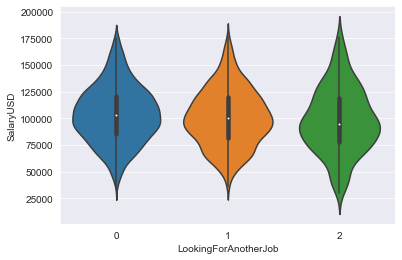

In [562]:
sns.violinplot(x='LookingForAnotherJob', y='SalaryUSD', data=sl)

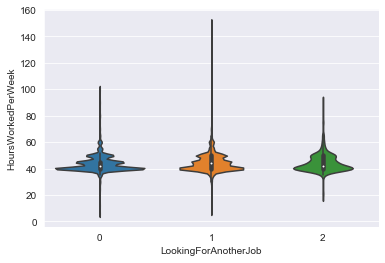

In [563]:
sns.violinplot(x='LookingForAnotherJob', y='HoursWorkedPerWeek', data=X)

**Splitting into 3 groups**

In [564]:
not_looking = X[X['LookingForAnotherJob'] == 0]
passively_looking = X[X['LookingForAnotherJob'] == 1]
actively_looking = X[X['LookingForAnotherJob'] == 2]

In [565]:
not_looking.isna().mean(), not_looking.shape

(SalaryUSD                 0.000000
 YearsWithThisDatabase     0.000850
 PrimaryDatabase           0.000000
 JobTitle                  0.000000
 ManageStaff               0.000000
 YearsWithThisTypeOfJob    0.000000
 OtherPeopleOnYourTeam     0.000000
 DatabaseServers           0.000000
 Education                 0.000000
 HoursWorkedPerWeek        0.000000
 TelecommuteDaysPerWeek    0.000000
 EmploymentSector          0.000000
 Gender                    0.405187
 od_count                  0.209184
 ojd_count                 0.405187
 LookingForAnotherJob      0.000000
 PostalCodeStates          0.069728
 dtype: float64, (2352, 17))

In [566]:
passively_looking.isna().mean(), passively_looking.shape

(SalaryUSD                 0.000000
 YearsWithThisDatabase     0.001623
 PrimaryDatabase           0.000000
 JobTitle                  0.000000
 ManageStaff               0.000000
 YearsWithThisTypeOfJob    0.000000
 OtherPeopleOnYourTeam     0.000000
 DatabaseServers           0.000000
 Education                 0.000000
 HoursWorkedPerWeek        0.000000
 TelecommuteDaysPerWeek    0.000000
 EmploymentSector          0.000000
 Gender                    0.437771
 od_count                  0.173701
 ojd_count                 0.437771
 LookingForAnotherJob      0.000000
 PostalCodeStates          0.066017
 dtype: float64, (1848, 17))

In [567]:
actively_looking.isna().mean(), actively_looking.shape

(SalaryUSD                 0.000000
 YearsWithThisDatabase     0.000000
 PrimaryDatabase           0.000000
 JobTitle                  0.000000
 ManageStaff               0.000000
 YearsWithThisTypeOfJob    0.000000
 OtherPeopleOnYourTeam     0.000000
 DatabaseServers           0.000000
 Education                 0.000000
 HoursWorkedPerWeek        0.000000
 TelecommuteDaysPerWeek    0.000000
 EmploymentSector          0.000000
 Gender                    0.379870
 od_count                  0.194805
 ojd_count                 0.379870
 LookingForAnotherJob      0.000000
 PostalCodeStates          0.051948
 dtype: float64, (308, 17))

### Testing, with a p value of 0.05

In [568]:
import scipy.stats as stats

#### Salary difference

In [569]:
nl_salary = not_looking['SalaryUSD']
pl_salary = passively_looking['SalaryUSD']
al_salary = actively_looking['SalaryUSD']

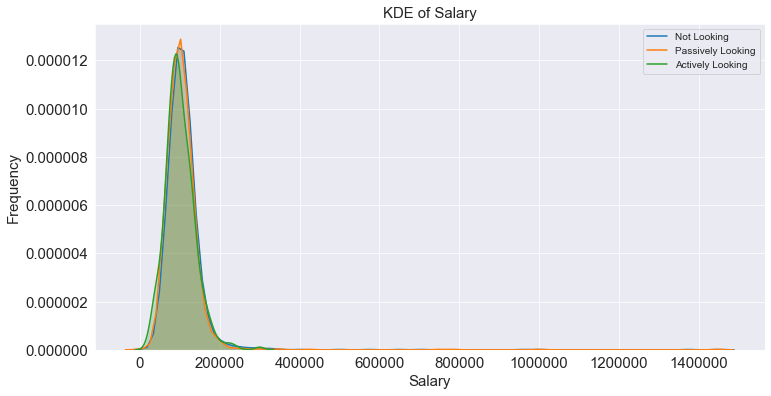

In [570]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_salary, pl_salary, al_salary, xlabel='Salary', ylabel='Frequency',
            title='KDE of Salary'))

In [571]:
nl_adj = outliers_removed(nl_salary)
pl_adj = outliers_removed(pl_salary)
al_adj = outliers_removed(al_salary)

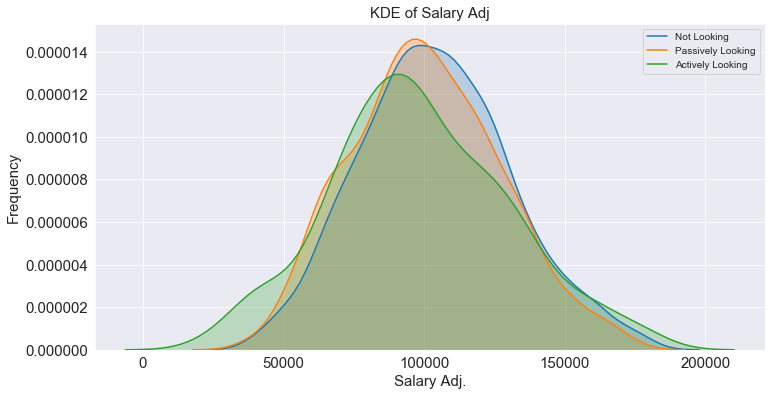

In [572]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_adj, pl_adj, al_adj, xlabel='Salary Adj.', ylabel='Frequency',
            title='KDE of Salary Adj'))

In [573]:
samps_ttest(not_looking['SalaryUSD'], passively_looking['SalaryUSD'], actively_looking['SalaryUSD'])

(('nl, pl', 0.0050872592302549716),
 ('pl, al', 0.10604738596970431),
 ('nl, al', 0.00024136075989482922))

In [574]:
samps_ttest(nl_adj, pl_adj, al_adj)

(('nl, pl', 3.706378998902741e-05),
 ('pl, al', 0.22117481672058284),
 ('nl, al', 0.002313316350332261))

In [575]:
# Not usable due to unequal variance
# stats.f_oneway(nl_adj, pl_adj, al_adj)

**Years With This Database**

In [576]:
nl_yrdb = not_looking['YearsWithThisDatabase']
pl_yrdb = passively_looking['YearsWithThisDatabase']
al_yrdb = actively_looking['YearsWithThisDatabase']

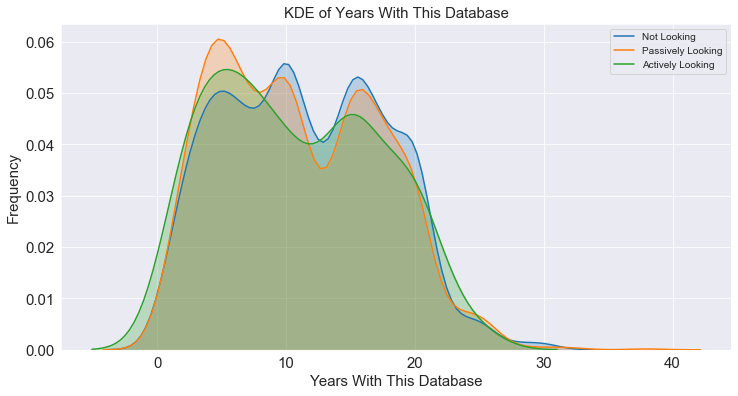

In [577]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_yrdb, pl_yrdb, al_yrdb, xlabel='Years With This Database', ylabel='Frequency',
            title='KDE of Years With This Database'))

In [578]:
samps_mwu(nl_yrdb, pl_yrdb, al_yrdb)

(('nl, pl', 0.004014591507134288),
 ('pl, al', 0.313014490260527),
 ('nl, al', 0.038738534681703254))

**Primary Database difference**

In [579]:
nl_pd = not_looking['PrimaryDatabase']
pl_pd = passively_looking['PrimaryDatabase']
al_pd = actively_looking['PrimaryDatabase']

In [580]:
p = samps_chi2(nl_pd, pl_pd, al_pd)

In [581]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


**Job Title**

In [582]:
nl_jt = not_looking['JobTitle']
pl_jt = passively_looking['JobTitle']
al_jt = actively_looking['JobTitle']

In [583]:
p = samps_chi2(nl_jt, pl_jt, al_jt)

In [584]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


**Other Databases Count**

In [585]:
nl_od = not_looking['od_count']
pl_od = passively_looking['od_count']
al_od = actively_looking['od_count']

In [586]:
p = samps_chi2(nl_od, pl_od, al_od)

In [587]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


**Manage Staff difference**

In [588]:
nl_ms = not_looking['ManageStaff']
pl_ms = passively_looking['ManageStaff']
al_ms = actively_looking['ManageStaff']

In [589]:
p = samps_chi2(nl_ms, pl_ms, al_ms)

In [590]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


**Years With This Type of Job**

In [591]:
nl_yrjob = not_looking['YearsWithThisTypeOfJob']
pl_yrjob = passively_looking['YearsWithThisTypeOfJob']
al_yrjob = actively_looking['YearsWithThisTypeOfJob']

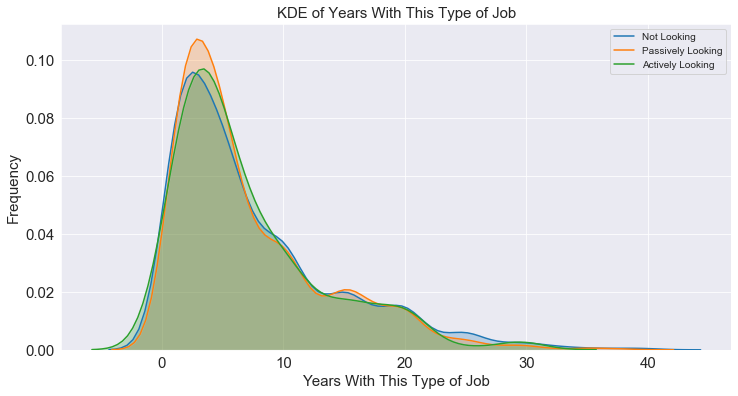

In [592]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_yrjob, pl_yrjob, al_yrjob, xlabel='Years With This Type of Job', ylabel='Frequency',
            title='KDE of Years With This Type of Job'))

In [593]:
samps_mwu(nl_yrjob, pl_yrjob, al_yrjob)

(('nl, pl', 0.2693892605440542),
 ('pl, al', 0.43486830424286727),
 ('nl, al', 0.3123631125279852))

**Other People On Your Team difference**

In [594]:
nl_people = not_looking['OtherPeopleOnYourTeam']
pl_people = passively_looking['OtherPeopleOnYourTeam']
al_people = actively_looking['OtherPeopleOnYourTeam']

In [595]:
p = samps_chi2(nl_people, pl_people, al_people)

In [596]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


**Education difference**

In [597]:
nl_edu = not_looking['Education']
pl_edu = passively_looking['Education']
al_edu = actively_looking['Education']

In [598]:
p = samps_chi2(nl_edu, pl_edu, al_edu)

In [599]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


**Hours of Work Per Week difference**

In [600]:
nl_hours = not_looking['HoursWorkedPerWeek']
pl_hours = passively_looking['HoursWorkedPerWeek']
al_hours = actively_looking['HoursWorkedPerWeek']

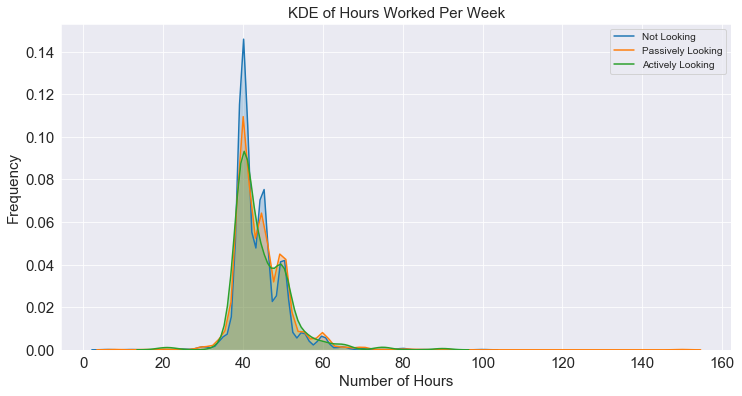

In [601]:
fig, ax = plt.subplots(figsize=(12, 6))
(plot_kde(ax, nl_hours, pl_hours, al_hours, xlabel='Number of Hours', ylabel='Frequency',
            title='KDE of Hours Worked Per Week'))

In [602]:
samps_mwu(nl_hours, pl_hours, al_hours)

(('nl, pl', 0.00021368578539696515),
 ('pl, al', 0.32743508474272764),
 ('nl, al', 0.09966110859741123))

**TelecommuteDaysPerWeek**

In [603]:
nl_tele = not_looking['TelecommuteDaysPerWeek']
pl_tele = passively_looking['TelecommuteDaysPerWeek']
al_tele = actively_looking['TelecommuteDaysPerWeek']

In [604]:
p = samps_chi2(nl_tele, pl_tele, al_tele)

In [605]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


**EmploymentSector**

In [606]:
nl_emp = not_looking['EmploymentSector']
pl_emp = passively_looking['EmploymentSector']
al_emp = actively_looking['EmploymentSector']

In [607]:
p = samps_chi2(nl_emp, pl_emp, al_emp)

In [608]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


### Gender

In [609]:
nl_gender = not_looking['Gender']
pl_gender = passively_looking['Gender']
al_gender = actively_looking['Gender']

In [610]:
p = samps_chi2(nl_gender, pl_gender, al_gender)

In [611]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


### OJD count

In [612]:
nl_ojd = not_looking['ojd_count']
pl_ojd = passively_looking['ojd_count']
al_ojd = actively_looking['ojd_count']

In [613]:
p = samps_chi2(nl_ojd, pl_ojd, al_ojd)

In [614]:
if 0.05 > p:
    print('Reject null')
else:
    print('Fail to reject null')

Fail to reject null


### Future plans

In [615]:
# countries_more_than_ten = countries.index[countries > 10]
# df = df[df['Country'].isin(countries_more_than_ten)]
# df.head()

### Predictive pipelines